In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, callbacks
from keras.layers import Dense, Dropout, BatchNormalization

In [12]:
df = pd.read_csv('Preprocessed Data 3 Mar 2021.csv', index_col = 0)
#df.head(5)
# Get the names of the features
feature_names = df.columns.tolist()

# Print the feature names
print(feature_names)

['Speed (km/h)', 'Latitude coordinate (degrees)', 'Longitude coordinate (degrees)', 'Altitude (meters)', 'Vertical accuracy (degrees)', 'Horizontal accuracy (degrees)', 'Course (degrees)', 'Difcourse: course variation (degrees)', 'Acceleration in X filtered by KF (Gs)', 'Acceleration in Y filtered by KF (Gs)', 'Acceleration in Z filtered by KF (Gs)', 'Roll (degrees)', 'Pitch (degrees)', 'Yaw (degrees)', 'X: car position relative to lane center (meters)', 'Phi: car angle relative to lane curvature (degrees)', 'W: road width (meters)', 'Distance to ahead vehicle in current lane (meters) [value -1 means no car is detected in front]', 'Time of impact to ahead vehicle (seconds) [distance related to own speed]', 'Number of detected vehicles in this frame (traffic)', 'Maximum allowed speed of current road (km/h)', 'Number of lanes in current road', 'OSM delay to answer query (seconds)', 'Estimated current lane_1', 'Estimated current lane_2', 'Estimated current lane_3', 'Reliability of obtaine

In [3]:
X = df.iloc[:,:-3]
Y = df.iloc[:,-3:]
kf = KFold(n_splits=5, random_state=4, shuffle=True)

In [4]:
count = 0

for train_index, test_index in kf.split(X):
    print('Fold: ' + str(count))

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # Compute class weights
    y_integers = np.argmax(Y_train, axis=1)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
    d_class_weights = dict(enumerate(class_weights))
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=40)

    model = keras.Sequential([
        layers.LSTM(units=70, input_shape=(1,X_train.shape[2]), return_sequences=True, activation="tanh"),
        Dropout(0.1),
        BatchNormalization(),
        
        layers.LSTM(units=80, return_sequences=True, activation="tanh"),
        Dropout(0.05),
        BatchNormalization(),
        
        layers.LSTM(units=70, return_sequences=True, activation="tanh"),
        Dropout(0.005),
        BatchNormalization(),
        
        layers.LSTM(units=80, activation="tanh"),
        Dropout(0.001),
        BatchNormalization(),
        
        Dense(3, 'softmax')
    ])

    optimizer = keras.optimizers.Adam()

    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

    model.summary()
    
    history = model.fit(X_train, Y_train, 
                    validation_data=(X_test, Y_test), 
                    callbacks=[early_stopping],
                    epochs=600,
                    class_weight=d_class_weights)  # Include class weights here
    
    # Saving history for plotting
    if count == 0:
        history_fold_0 = pd.DataFrame(history.history)
    elif count == 1:
        history_fold_1 = pd.DataFrame(history.history)
    elif count == 2:
        history_fold_2 = pd.DataFrame(history.history)
    elif count == 3:
        history_fold_3 = pd.DataFrame(history.history)
    elif count == 4:
        history_fold_4 = pd.DataFrame(history.history)
    
    count += 1

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels from one-hot encoding to class labels if necessary
y_true_classes = np.argmax(Y_test, axis=1)

# Calculate and display precision, recall, and F1-score for each class
print("Evaluation Metrics Per Class:")
print(classification_report(y_true_classes, y_pred_classes, target_names=['Class 1', 'Class 2', 'Class 3']))

Fold: 0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 70)          │        31,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 70)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 70)          │           280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 80)          │        48,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 80)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 80)          │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 70)          │        42,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 70)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 70)          │           280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 80)             │        48,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           243 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,443 (669.70 KB)

 Trainable params: 170,843 (667.36 KB)

 Non-trainable params: 600 (2.34 KB)

Epoch 1/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5631 - loss: 0.8690 - precision: 0.6013 - recall: 0.4890 - val_accuracy: 0.7054 - val_loss: 0.6473 - val_precision: 0.7425 - val_recall: 0.6633
Epoch 2/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7294 - loss: 0.5766 - precision: 0.7631 - recall: 0.6864 - val_accuracy: 0.7999 - val_loss: 0.4709 - val_precision: 0.8171 - val_recall: 0.7791
Epoch 3/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7840 - loss: 0.4755 - precision: 0.8040 - recall: 0.7576 - val_accuracy: 0.8300 - val_loss: 0.3975 - val_precision: 0.8460 - val_recall: 0.8099
Epoch 4/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8136 - loss: 0.4263 - precision: 0.8309 - recall: 0.7943 - val_accuracy: 0.8328 - val_loss: 0.3874 - val_precision: 0.8476 - val_recall: 0.8162
Epoch 5/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8312 - loss: 0.3847 - precision: 0.8497 - recall: 0.8153 - val_accuracy: 0.8518 - val_los

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 1, 70)          │        31,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 70)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1, 70)          │           280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 1, 80)          │        48,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 80)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 80)          │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 1, 70)          │        42,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 70)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1, 70)          │           280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 80)             │        48,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           243 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,443 (669.70 KB)

 Trainable params: 170,843 (667.36 KB)

 Non-trainable params: 600 (2.34 KB)

Epoch 1/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5773 - loss: 0.8620 - precision: 0.6182 - recall: 0.5023 - val_accuracy: 0.7474 - val_loss: 0.5451 - val_precision: 0.7829 - val_recall: 0.7084
Epoch 2/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7412 - loss: 0.5572 - precision: 0.7708 - recall: 0.7012 - val_accuracy: 0.7703 - val_loss: 0.5122 - val_precision: 0.7841 - val_recall: 0.7503
Epoch 3/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7878 - loss: 0.4713 - precision: 0.8119 - recall: 0.7629 - val_accuracy: 0.8310 - val_loss: 0.3790 - val_precision: 0.8433 - val_recall: 0.8178
Epoch 4/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8290 - loss: 0.3958 - precision: 0.8469 - recall: 0.8104 - val_accuracy: 0.8505 - val_loss: 0.3446 - val_precision: 0.8600 - val_recall: 0.8391
Epoch 5/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8386 - loss: 0.3748 - precision: 0.8514 - recall: 0.8236 - val_accuracy: 0.8051 - val_los

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 1, 70)          │        31,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 70)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1, 70)          │           280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 1, 80)          │        48,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1, 80)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1, 80)          │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 1, 70)          │        42,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1, 70)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1, 70)          │           280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 80)             │        48,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           243 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,443 (669.70 KB)

 Trainable params: 170,843 (667.36 KB)

 Non-trainable params: 600 (2.34 KB)

Epoch 1/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5577 - loss: 0.8784 - precision: 0.5928 - recall: 0.4875 - val_accuracy: 0.7147 - val_loss: 0.6353 - val_precision: 0.7378 - val_recall: 0.6898
Epoch 2/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7395 - loss: 0.5569 - precision: 0.7667 - recall: 0.7031 - val_accuracy: 0.7817 - val_loss: 0.4934 - val_precision: 0.8036 - val_recall: 0.7541
Epoch 3/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7829 - loss: 0.4696 - precision: 0.8063 - recall: 0.7584 - val_accuracy: 0.8333 - val_loss: 0.3871 - val_precision: 0.8514 - val_recall: 0.8146
Epoch 4/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8118 - loss: 0.4220 - precision: 0.8284 - recall: 0.7898 - val_accuracy: 0.8051 - val_loss: 0.4589 - val_precision: 0.8170 - val_recall: 0.7895
Epoch 5/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8302 - loss: 0.3931 - precision: 0.8459 - recall: 0.8131 - val_accuracy: 0.8624 - val_los

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 1, 70)          │        31,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1, 70)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1, 70)          │           280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 1, 80)          │        48,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1, 80)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 1, 80)          │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 1, 70)          │        42,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1, 70)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 1, 70)          │           280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 80)             │        48,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           243 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,443 (669.70 KB)

 Trainable params: 170,843 (667.36 KB)

 Non-trainable params: 600 (2.34 KB)

Epoch 1/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5714 - loss: 0.8750 - precision: 0.6059 - recall: 0.4948 - val_accuracy: 0.7365 - val_loss: 0.5588 - val_precision: 0.7756 - val_recall: 0.6875
Epoch 2/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7361 - loss: 0.5707 - precision: 0.7676 - recall: 0.6943 - val_accuracy: 0.8204 - val_loss: 0.4222 - val_precision: 0.8398 - val_recall: 0.7903
Epoch 3/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7845 - loss: 0.4753 - precision: 0.8067 - recall: 0.7570 - val_accuracy: 0.8177 - val_loss: 0.4088 - val_precision: 0.8364 - val_recall: 0.8035
Epoch 4/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8139 - loss: 0.4204 - precision: 0.8331 - recall: 0.7939 - val_accuracy: 0.8333 - val_loss: 0.3809 - val_precision: 0.8471 - val_recall: 0.8144
Epoch 5/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8301 - loss: 0.3782 - precision: 0.8464 - recall: 0.8138 - val_accuracy: 0.8697 - val_los

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 1, 70)          │        31,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1, 70)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 1, 70)          │           280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 1, 80)          │        48,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 1, 80)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 1, 80)          │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 1, 70)          │        42,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1, 70)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 1, 70)          │           280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 80)             │        48,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           243 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,443 (669.70 KB)

 Trainable params: 170,843 (667.36 KB)

 Non-trainable params: 600 (2.34 KB)

Epoch 1/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5773 - loss: 0.8479 - precision: 0.6142 - recall: 0.4985 - val_accuracy: 0.7345 - val_loss: 0.5799 - val_precision: 0.7673 - val_recall: 0.7006
Epoch 2/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7422 - loss: 0.5537 - precision: 0.7705 - recall: 0.7048 - val_accuracy: 0.8112 - val_loss: 0.4319 - val_precision: 0.8316 - val_recall: 0.7910
Epoch 3/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8019 - loss: 0.4444 - precision: 0.8235 - recall: 0.7773 - val_accuracy: 0.8534 - val_loss: 0.3473 - val_precision: 0.8709 - val_recall: 0.8382
Epoch 4/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8311 - loss: 0.3984 - precision: 0.8454 - recall: 0.8100 - val_accuracy: 0.8497 - val_loss: 0.3718 - val_precision: 0.8601 - val_recall: 0.8383
Epoch 5/600
769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8465 - loss: 0.3566 - precision: 0.8607 - recall: 0.8334 - val_accuracy: 0.8946 - val_los

In [5]:
precision = history.history['val_precision'][-1]  
recall = history.history['val_recall'][-1] 
f1_score = 2 * (precision * recall) / (precision + recall)
print(f1_score, precision, recall)

0.9808005247901264 0.9811198115348816 0.9804814457893372


In [6]:
final_result = pd.concat([history_fold_0[-1:],
                          history_fold_1[-1:],
                          history_fold_2[-1:],
                          history_fold_3[-1:],
                          history_fold_4[-1:],
                         ])
final_result.columns = ['Last Training Accuracy', 'Last Training Loss (Crossentropy)','training precision','training recall', 'Last Validation Accuracy', 'Last Validation Loss (Crossentropy)','validation precision','validation recall']
final_result = final_result.reset_index(drop = True)
final_result.index += 1 
final_result.index.name = 'Fold'
final_result['Last Training Accuracy'] *= 100
final_result['Last Validation Accuracy'] *= 100
final_result['Last Training Loss (Crossentropy)'] = final_result['Last Training Loss (Crossentropy)'].round(5)
final_result['Last Validation Loss (Crossentropy)'] = final_result['Last Validation Loss (Crossentropy)'].round(5)
final_result['Last Training Accuracy'] = final_result['Last Training Accuracy'].round(2)
final_result['Last Validation Accuracy'] = final_result['Last Validation Accuracy'].round(2)

final_result

,Last Training Accuracy,Last Training Loss (Crossentropy),training precision,training recall,Last Validation Accuracy,Last Validation Loss (Crossentropy),validation precision,validation recall
Fold,,,,,,,,
1,97.68,0.06371,0.977128,0.976334,97.66,0.07645,0.977055,0.976578
2,97.44,0.06822,0.975009,0.974097,96.15,0.11159,0.962058,0.960963
3,97.52,0.06498,0.975463,0.974789,98.24,0.06164,0.982590,0.982271
4,97.96,0.05398,0.979980,0.979343,98.63,0.04812,0.986819,0.986337
5,97.65,0.06195,0.977122,0.976049,98.08,0.06282,0.981120,0.980481


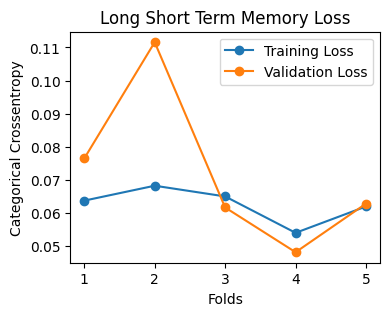

In [7]:
plt.figure(figsize = [4,3])
plt.plot(final_result.loc[:, ['Last Training Loss (Crossentropy)', 'Last Validation Loss (Crossentropy)']],'o-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('Long Short Term Memory Loss')
plt.xticks(np.arange(1,6,1))
plt.xlabel('Folds')
plt.ylabel('Categorical Crossentropy')
plt.show()

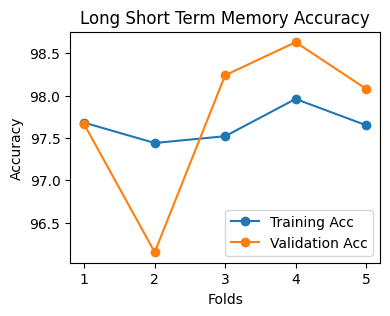

In [8]:
plt.figure(figsize = [4,3])
plt.plot(final_result.loc[:, ['Last Training Accuracy', 'Last Validation Accuracy']],'o-')
plt.legend(['Training Acc', 'Validation Acc'])
plt.title('Long Short Term Memory Accuracy')
plt.xticks(np.arange(1, 6, 1))
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.show()

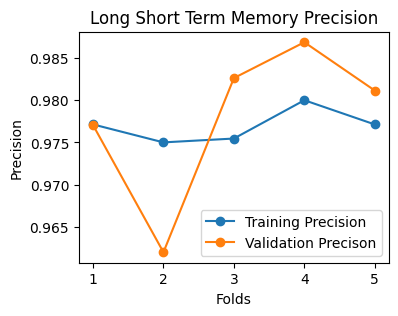

In [9]:
plt.figure(figsize = [4,3])
plt.plot(final_result.loc[:, ['training precision', 'validation precision']],'o-')
plt.legend(['Training Precision', 'Validation Precison'])
plt.title('Long Short Term Memory Precision')
plt.xticks(np.arange(1, 6, 1))
plt.xlabel('Folds')
plt.ylabel('Precision')
plt.show()

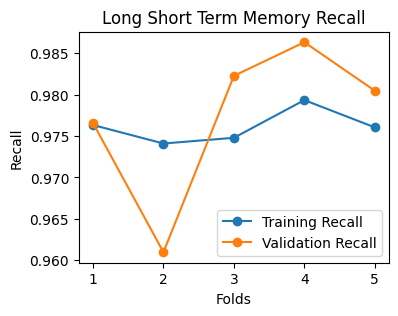

In [10]:
plt.figure(figsize = [4,3])
plt.plot(final_result.loc[:, ['training recall', 'validation recall']],'o-')
plt.legend(['Training Recall', 'Validation Recall'])
plt.title('Long Short Term Memory Recall')
plt.xticks(np.arange(1, 6, 1))
plt.xlabel('Folds')
plt.ylabel('Recall')
plt.show()

In [11]:
average_validation_accuracy = final_result['Last Validation Accuracy'].mean()

print(f"The average validation accuracy is: {average_validation_accuracy}%")

The average validation accuracy is: 97.752%
